In [1]:
# Import required libraries and functions
from acquire import get_telco_data
from prepare import train_validate_test_split, prep_telco
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

import model

import warnings
warnings.filterwarnings("ignore")

# Reducing Telco Churn
### The goal of this project was to identify drivers of customer churn at Telco. I used statistical testing and machine learning classification models to provide insight into why customers churn and provide recommendations for reducing customer churn.

# Acquire and Prepare Telco Churn Data

To acquire the Telco churn data I used the telco_churn database in our mySQL server and selected all columns from the customers, contract types, payment types, and internet service types

In [2]:
# Acquire data from sql database telco_churn
df = get_telco_data()

Using cached data


## Prepare Steps:
- Drop null/blank values. From prior exploration of dataset a small number of the total_charges are just whitespace - these are all new customers who haven't been with the company for >1 month. Given that it is a very small proportion of the total dataset (< 0.5%) these rows will be deleted for ease of computation later on
- Encode categorical variables
- Renaming and removing unnecessary columns after encoding

In [3]:
# Run acquired data through prepare script and split into train, validate and test sets
df = prep_telco(df)
train, validate, test = train_validate_test_split(df, target = 'churn', seed =123)

- The data is now split into 3 samples so that we can use the train sample to explore, fit the models, and evaluate without looking at new data
- The validate set is used to verify the models built are not overfit to the train dataset
- The test set will give an indication of how the model performs on unseen future data

# Exploratory Analysis: Who is most likely to churn?

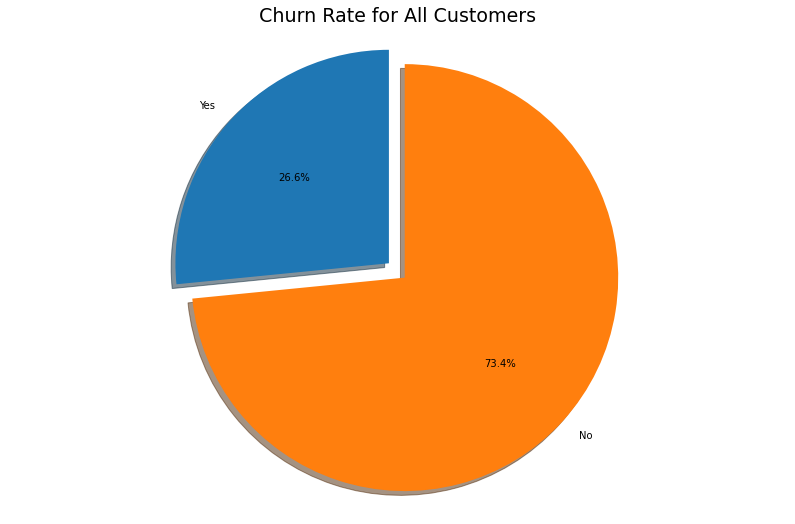

In [4]:
# Baseline churn: create DataFrame of churn values
churn_df = pd.DataFrame({'Yes':train.churn.sum(),'No':(train.churn == 0).sum()}, index = ['Churn']).T
labels = churn_df.index
sizes = churn_df.Churn
explode = (0, 0.1)
fig1, ax1 = plt.subplots(figsize=(14,9))
# Create pie chart of churn vs no churn
p = ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
p = ax1.axis('equal')
p = plt.title('Churn Rate for All Customers', fontsize = 19)

In [5]:
# Set the baseline churn to a variable
baseline_churn = (train.churn == 1).mean()

## Our churn rate for all customers is 26.6%

## Question 1: Do any groups churn at rates significantly above or below the overall average?

### Groups defined as:
    - senior citizen
    - male vs female
    - partner vs no partner
    - dependent vs no dependent
    - Auto vs manual payers
    - Paperless billing vs not
    - Month to month vs long term
    - Internet service or not
    - Phone service or not
### Will perform chi squared tests to establish whether the churn rate is independent of whether someone is a member of that group or not

In [6]:
# Set alpha level for significance
alpha = 0.05

In [7]:
# Establish a list of the groups to be tested
groups = ['is_male', 'is_senior_citizen', 'has_partner', 'has_dependent', 'is_paperless','is_autopay','is_month_to_month','has_phone','has_internet_service','has_streaming']
reject_null = []
churn_rate=[]
# Iterate through groups and perform chi square test for each. Save churn rate and test result to lists
for group in groups:
    observed = pd.crosstab(train.churn, train[group])
    chi2, p, dof, expected = stats.chi2_contingency(observed)
    churn_rate.append((train.churn[train[group] == 1]).mean())
    reject_null.append(p<alpha)
    
# Create pandas DataFrame for plotting
results = pd.DataFrame(data = {'churn_rate':churn_rate,'reject_null':reject_null},index = groups)
results = results.sort_values(by= 'churn_rate')

results.index = ['Has Dependent', 'Has Autopay', 'Has Partner', 'Is Male', 'Has Phone Service',
       'Has Streaming', 'Has Internet Service', 'Paperless Billing',
       'Is Senior Citizen', 'Month-to-month\ncontract']

Text(109.0, 0.5, 'Churn Rate')

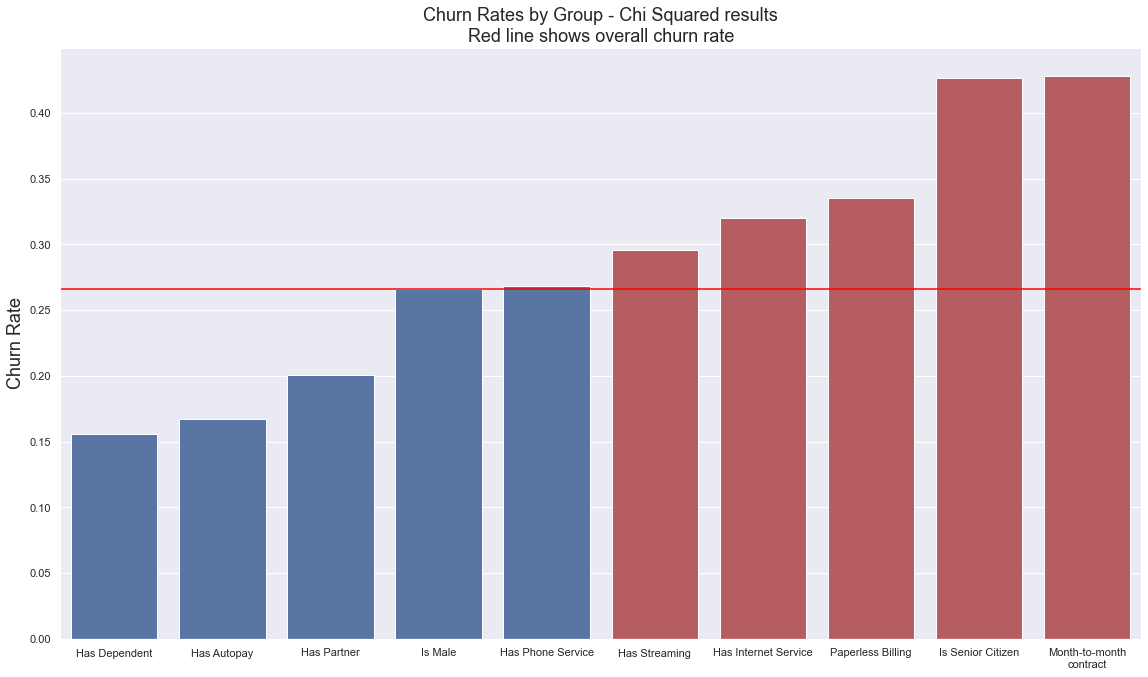

In [8]:
# Plot bar plot of results, highlighting which groups we can reject the null hypothesis - ie there is a relationshio
sns.set(rc={'figure.figsize':(16,9)})
colors = ('b','b','b','b','b','r','r','r','r','r')
sns.barplot(data = results, x = results.index ,y = 'churn_rate', palette = colors)
plt.tight_layout()
plt.title('Churn Rates by Group - Chi Squared results\nRed line shows overall churn rate', fontsize = 18)
plt.axhline(y=baseline_churn, color = 'red')
plt.ylabel('Churn Rate', fontsize = 18)

### Five groups churn at rates significantly higher than the overall mean:
    - Senior citizens: 43%
    - Month to Month: 43%
    - Paperless billing: 34%
    - Those with internet service: 32%
    - Those with streaming service: 30%

### Three groups churn at rates significantly below the overall mean:
    - With dependents: 16%
    - Autopayers: 17%
    - With partners: 20%

## Recommend focusing efforts to reduce churn at the company on the higher churning groups. Recommend looking at how we are succeeding with the groups who churn at lower than the average rate and see if we can apply any lessons to the higher churners.

# Question 2: Do the churners on the month to month plan pay higher per month on average than those who don't churn on month to month?
### Will perform a 2 sample t-test to check

In [9]:
# Create the independent samples
month_to_month = train[train.is_month_to_month==1]
churn_sample = month_to_month[month_to_month.churn == 1].monthly_charges
non_churn_sample = month_to_month[month_to_month.churn == 0].monthly_charges
# Perform the t-test
t, p = stats.ttest_ind(churn_sample, non_churn_sample, equal_var=False)
print(f"t: {t}, p/2 < alpha: {p/2<alpha}")

t: 11.098473710039949, p/2 < alpha: True


([0, 1], [Text(0, 0, ''), Text(0, 0, '')])

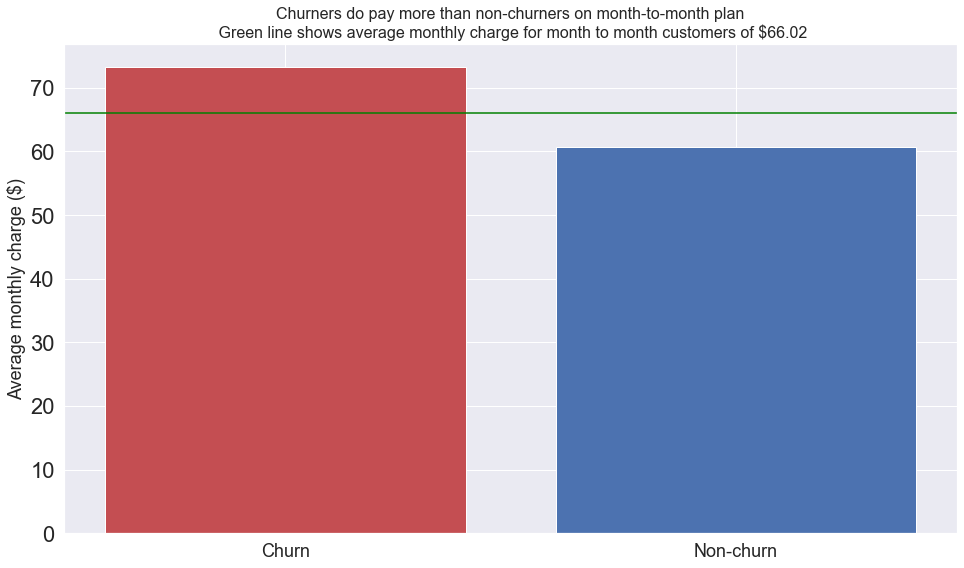

In [31]:
plt.bar(x=['Churn','Non-churn'], height =[churn_sample.mean(),non_churn_sample.mean()], color = ('r','b'))
plt.title(f'Churners do pay more than non-churners on month-to-month plan\n Green line shows average monthly charge for month to month customers of ${month_to_month.monthly_charges.mean():.2f}', fontsize = 16)
plt.axhline(month_to_month.monthly_charges.mean(), color = 'green')
plt.ylabel('Average monthly charge ($)', fontsize = 18)
plt.xticks (fontsize=18)


## Those who churn on the month to month plan do in fact pay more than those who do not churn
- Cost may be a factor causing them to churn
- Recommend examining options for discounting this service

# Question 3: Does the type of internet service (Fiber vs DSL) have a relationship with whether a customer will churn?
- Customers with internet service are one of the higher churning groups
- Will perform a chi square test to check

[Text(0.5, 0, 'DSL'), Text(1.5, 0, 'Fiber optic')]

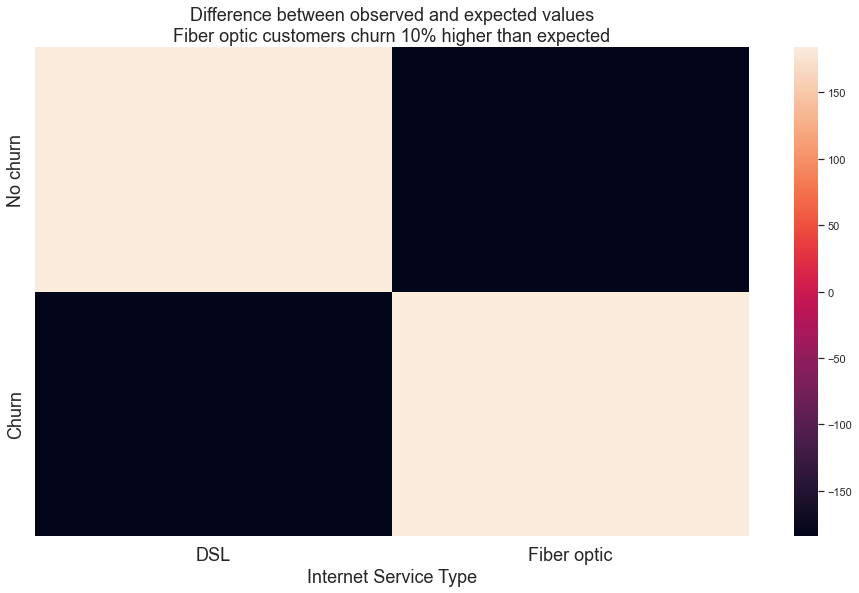

In [11]:
# create a dataframe of just internet customers from train
internet = train[train.has_internet_service == 1]
# create the observed dataframe of churn vs service type
observed = pd.crosstab(internet.churn, internet.internet_service_type)
chi2, p, dof, expected = stats.chi2_contingency(observed)
# create heatmap showing observed vs expected
observed.index.name=""
expected_df = pd.DataFrame(expected,index=[0,1], columns=['DSL','Fiber optic'])
observed - expected_df
ax = sns.heatmap(data = observed-expected_df, yticklabels=['No churn','Churn'])
ax.set_title('Difference between observed and expected values\nFiber optic customers churn 10% higher than expected', fontsize = 18)
ax.set_xlabel('Internet Service Type', fontsize = 18)
ax.set_yticklabels(['No churn','Churn'],fontsize = 18)
ax.set_xticklabels(['DSL','Fiber optic'],fontsize = 18)

## Churn and the type of internet service are not independent: fiber optic customers churn at a rate 10% higher than we'd expect. This is >180 additional customers churned.
- Customers seem to be more dissatisfied with our fiber internet service than our DSL
- Recommend examining how this service quality differs from DSL and looking into ways to improve it

# Question 4: Is whether a fiber customer churns independent of whether he or she has a streaming service? TV, Movies, or both. 

#### Looking at the internet service group, there are several options:
- Streaming TV
- Streaming movies
- Various support and additional features

#### Chi squared test performed to test

In [12]:
# Create a dataframe of just fiber customers
fiber = train[train.internet_service_type == 'Fiber optic']

observed = pd.crosstab(fiber.churn, fiber.has_streaming)
# Perform the chi2 test
chi2, p, dof, expected = stats.chi2_contingency(observed)

In [13]:
print(f"p<alpha: {p<alpha}")

p<alpha: True


Text(0.5, 1.0, 'Churn Rate for Streamers vs Non Streamers\nStreamers Have Lower Churn Rates Than Non-Streamers')

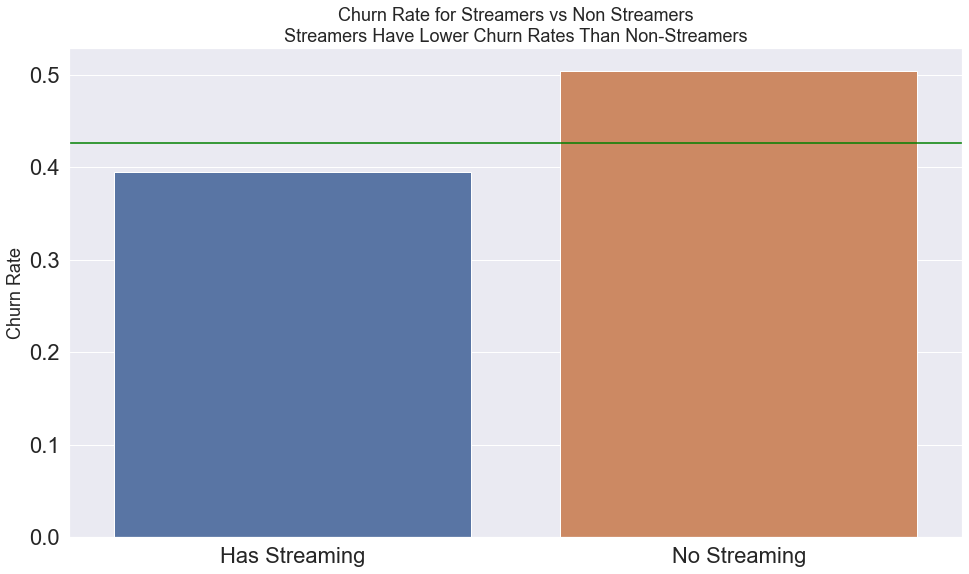

In [14]:
# Create bar plot showing churn rate for streamers vs non streamers, with a horizontal line indicating the group average
sns.set(font_scale = 2)
p = sns.barplot(x=['Has Streaming', 'No Streaming'], y = [(fiber.churn[fiber.has_streaming]).mean(),(fiber.churn[~fiber.has_streaming]).mean()])
p.axhline(fiber.churn.mean(), color = "green")
p.set_ylabel('Churn Rate', fontsize = 18)
p.set_title('Churn Rate for Streamers vs Non Streamers\nStreamers Have Lower Churn Rates Than Non-Streamers', fontsize = 18)


## Fiber customers with streaming service are more satisfied than those who don't have it. 
- Still, both streamers and non-streamers churn at rates much greater than the overall average. 
- Recommend promoting streaming for now but we should further examine this category for why a higher than expected proportion of customers are churning.

## --Exploration Takeaways--
- A few groups churn at rates greater than the average. These include:
    - month to month plan customers
    - those with internet service
- Looking closer at the month to month plan partipants, those who churn do pay more on average than those who stay. This implies cost may be a driver of churn for these customers.
- Examining the internet service customers, fiber customers do churn on average 10% more than we'd expect. Perhaps our fiber service needs to be enhanced.
- Streaming affect on fiber customers: those with streaming churn at a lower rate than those who don't have streaming. Still - churn rates for both streamers and non-streamers are above the overall average.

# Predicting Churn

- Four classification algorithms evaluated to predict churn. 
- Exploration results and further model exploration were used to select features for the models:
    - Monthly charges
    - Month to month contract type
    - Has Streaming
    - Tenure
    - Senior Citizen (higher churn rate)
    - Paperless billing (higher churn rate)

#### My baseline is if we simply predicted everyone did not churn (given that the majority of individuals in the dataset do not churn). This would give an accuracy of 73%.

In [15]:
# Most common class is 0 (no churn)
baseline_accuracy = (train.churn == 0).mean()

In [16]:
# Define selected features for model, based on exploration phase
selected_features = ['monthly_charges',
                     'is_autopay',
                     'has_internet_service',
                     'tenure',
                     'is_month_to_month',
                     'has_streaming',
                     'is_senior_citizen',
                     'is_paperless']

# Define target
target = 'churn'

In [17]:
# Splitting the train, validate, and test sets 
X_train = train[selected_features]
y_train = train[[target]]

X_validate = validate[selected_features]
y_validate = validate[[target]]

X_test = test[selected_features]
y_test = test[[target]]

## Decision Tree and Random Forest Models

In [18]:
# Collect results for all models in a dataframe all_results
all_results = pd.DataFrame()

# Set range of tested hyperparameters
min_samples_range = range(1,10)
d_range = range(1,10)

# Iterates through both decision tree and random forest models. These models share the same hyperparameters
for model_name in ['decision_tree','random_forest']:
    # Define empty lists to record results
    depths =[]
    min_samples = []
    train_accuracies = []
    train_precisions = []
    train_recalls = []

    v_accuracies = []
    v_precisions = []
    v_recalls = []
    # Iterate through max depth values
    for d in d_range:
        # Iterate through min_samples_leaf values
        for min_sample in min_samples_range:
            if model_name == 'decision_tree':
                # Fit model on train data (decision tree)
                clf, train_report = model.decision_tree_train(X_train, 
                                                              y_train, 
                                                              selected_features,
                                                              target, 
                                                              d=d, 
                                                              m = min_sample, 
                                                              print_results=False)
            else:
                # Fit model on train data (random forest)
                clf, train_report = model.random_forest_train(X_train,
                                                              y_train,
                                                              selected_features,
                                                              target,
                                                              d=d,
                                                              m = min_sample,
                                                              print_results=False)
            # Test model on validate data    
            validate_report = model.classifier_validate(X_validate,y_validate, clf, print_results=False)
            
            # Compile results into dataframe
            depths.append(d)
            min_samples.append(min_sample)
            train_accuracies.append(train_report['accuracy'])
            train_precisions.append(train_report['precision'])
            train_recalls.append(train_report['recall'])

            v_accuracies.append(validate_report['accuracy'])
            v_precisions.append(validate_report['precision'])
            v_recalls.append(validate_report['recall'])
            
    train_results_df= pd.DataFrame(data = {"max_depth":depths,
                                           "min_samples_leaf":min_samples,
                                           "accuracy":train_accuracies,
                                           "precision":train_precisions,
                                           "recall":train_recalls})
    validate_results_df= pd.DataFrame(data = {"max_depth":depths,
                                              "min_samples_leaf":min_samples,
                                              "accuracy":v_accuracies,
                                              "precision":v_precisions,
                                              "recall":v_recalls})
    # Combine train and validate results as well as calculate difference in performance between train and validate
    combined_df = model.consolidate_results(train_results_df, 
                                            validate_results_df, 
                                            join_on = ['max_depth','min_samples_leaf'])
    combined_df["algorithm"] = model_name
    # Concatenate results into one dataframe to hold results for all models
    all_results = pd.concat([all_results,combined_df])

## K Nearest Neighbors

In [19]:
ks =[]
train_accuracies = []
train_precisions = []
train_recalls = []

v_accuracies = []
v_precisions = []
v_recalls = []
# Testing the k value (nearest neighbors) hyperparameter only
k_range = range(1,100)
# Iterate through k values
for k in k_range:
    # Fit model to train
    clf, train_report = model.knn_train(X_train, y_train,selected_features,target, k=k, print_results=False)
    # Test model on validate 
    validate_report = model.knn_validate(X_validate,y_validate, clf, print_results=False)

    ks.append(k)
    min_samples.append(min_sample)
    train_accuracies.append(train_report['accuracy'])
    train_precisions.append(train_report['precision'])
    train_recalls.append(train_report['recall'])

    v_accuracies.append(validate_report['accuracy'])
    v_precisions.append(validate_report['precision'])
    v_recalls.append(validate_report['recall'])
    
# Compile results into dataframe
train_results_df= pd.DataFrame(data = {"k":ks,"accuracy":train_accuracies,"precision":train_precisions,"recall":train_recalls})
validate_results_df= pd.DataFrame(data = {"k":ks,"accuracy":v_accuracies,"precision":v_precisions,"recall":v_recalls})

# Combine train and validate results as well as calculate difference in performance between train and validate
combined_df = model.consolidate_results(train_results_df, validate_results_df, join_on = ['k'])
combined_df["algorithm"] = "k_nearest_neighbors"
# Concatenate results into one dataframe to hold results for all models
all_results = pd.concat([all_results,combined_df])

## Logistic Regression

In [20]:
cs =[]
train_accuracies = []
train_precisions = []
train_recalls = []

v_accuracies = []
v_precisions = []
v_recalls = []

# Testing the c value (inverse of regularization strength) hyperparameter
c_range = np.linspace(0.01, 10000, num = 50)
for c in c_range:
    # Fit model to train
    clf, train_report = model.logistic_regression_train(X_train, y_train,selected_features,target, c=c, print_results=False)
    # Test model on validate
    validate_report = model.logistic_regression_validate(X_validate,y_validate, clf, print_results=False)

    cs.append(clf.C)
    min_samples.append(min_sample)
    train_accuracies.append(train_report['accuracy'])
    train_precisions.append(train_report['precision'])
    train_recalls.append(train_report['recall'])

    v_accuracies.append(validate_report['accuracy'])
    v_precisions.append(validate_report['precision'])
    v_recalls.append(validate_report['recall'])
    
train_results_df= pd.DataFrame(data = {"c":cs,"accuracy":train_accuracies,"precision":train_precisions,"recall":train_recalls})
validate_results_df= pd.DataFrame(data = {"c":cs,"accuracy":v_accuracies,"precision":v_precisions,"recall":v_recalls})


combined_df = model.consolidate_results(train_results_df, validate_results_df, join_on = ['c'])
combined_df["algorithm"] = "logistic_regression"
all_results = pd.concat([all_results,combined_df])

# Modeling Results

In [21]:
all_results.shape

(311, 15)

### In total 311 models trained and tested on validate.
- Results filtered to models in top quartile of accuracy drop-off from the train to validate set to minimize risk of overfitting. 
    - Performance then ranked using the accuracy values obtained on the validate set.

In [22]:
# Identify the top quartile 
top_quarter = all_results.accuracy_pct_diff.quantile(0.75)
# Create a dataframe of only those results in the top quartile by pct accuracy difference
filtered = all_results[all_results.accuracy_pct_diff>top_quarter]

In [23]:
# Show top 3 models
filtered[filtered.columns[-2:2:-1]].sort_values(by="accuracy_validate", ascending=False).head(3)

,k,algorithm,accuracy_pct_diff,recall_diff,precision_diff,accuracy_diff,recall_validate,precision_validate,accuracy_validate,recall_train,precision_train
86,87.0,k_nearest_neighbors,-0.012122,0.007554,-0.036562,-0.009646,0.458797,0.635802,0.786137,0.451243,0.672365
83,84.0,k_nearest_neighbors,-0.012235,0.005979,-0.037343,-0.009731,0.447661,0.638095,0.785545,0.441683,0.675439
82,83.0,k_nearest_neighbors,-0.013925,0.003100,-0.039783,-0.011085,0.454343,0.633540,0.784953,0.451243,0.673324


## Top 3 models all use the K Nearest Neighbors algorithm and have k values of:
## 87 (top), 84 and 83. 
### Validate accuracy is 0.786
### Precision is 0.635
### Recall is 0.459

### This model will be tested on the test set

In [24]:
clf, train_report = model.knn_train(X_train, y_train, selected_features, target, k=87, print_results=False)
test_report = model.knn_validate(X_test, y_test, clf)

-----VALIDATE/TEST RESULTS: KNeighborsClassifier-----
Using features: ['monthly_charges', 'is_autopay', 'has_internet_service', 'tenure', 'is_month_to_month', 'has_streaming', 'is_senior_citizen', 'is_paperless']
K of 87
              precision    recall  f1-score   support

           0       0.83      0.91      0.87      1033
           1       0.66      0.47      0.55       374

    accuracy                           0.79      1407
   macro avg       0.74      0.69      0.71      1407
weighted avg       0.78      0.79      0.78      1407

Accuracy on validate/test set: 0.79


## Accuracy of 0.79
## Precision of 0.66
## Recall of 0.47

In [25]:
# Create dataframe of the test report
test_report = pd.DataFrame(data = [test_report])
# Append '_test' to each column in test
test_report.columns = [c+'_test' for c in test_report]
# Get row for selected k value
final_result = all_results[all_results.k == 87]
# Merge train, validate, and test results into one dataframe
final_result = pd.merge(final_result, test_report,left_on='k',right_on='k_test')

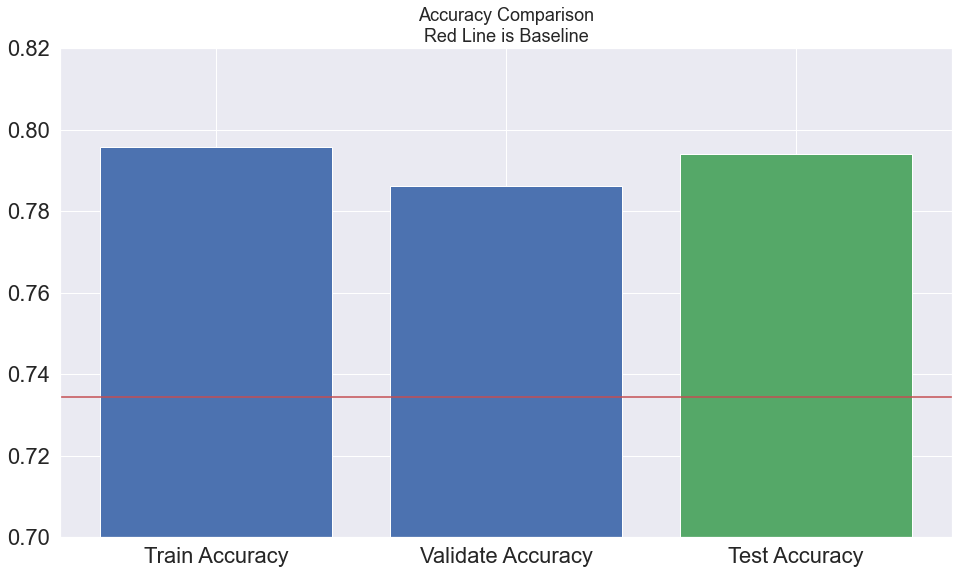

In [26]:
# Compare accuracy from different data sets
plt.bar(x=['Train Accuracy',
           'Validate Accuracy',
           'Test Accuracy'],
        height = [final_result.accuracy_train[0], final_result.accuracy_validate[0], final_result.accuracy_test[0]],
       color = ('b','b','g'))
plt.ylim(0.7,0.82)
plt.title('Accuracy Comparison\nRed Line is Baseline', fontsize=18)
plt.axhline(baseline_accuracy, color = 'r')

## Accuracy actually improves slightly from Validate to Test, and a 6% improvement over baseline
- I recommend using this model to target customers more likely to churn with offers or promotions.


# Conclusion
- A variety of factors were evaluated using statistical testing to determine drivers of churn at Telco.
- Monthly charges for month-to-month customers as well as fiber optic internet service vs DSL were shown to have an influence on whether a customer churns or not.
- Fiber streaming customers churn less than those without streaming. Still - churn rates for both streamers and non-streamers are above the overall average.
- Predicting whether a customer churns or not is possible at an accuracy 6% better than baseline using a k-nearest neighbors classification model.